In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
pd.set_option("display.max_rows", 100)
# import xml.etree.ElementTree as ET
import cv2
import rasterio
from rasterio.plot import show as rastershow
import matplotlib.pyplot as plt
%matplotlib inline

import json

# import sys
# sys.path.append("..")
# from bbox.connectors import SfMComponents, BBoxComponents
# from bbox.bbox_transformations import BBoxMapper, BBoxFilter
# from bbox.io_utils import ParseXML, ParseYOLOCsv

In [2]:
trial = "NC_2022-03-29"

In [3]:
base_path = f"../data/trial/{trial}"
# connector = SfMComponents(base_path)
# gcp_reference = connector.gcp_reference
# camera_reference = connector.camera_reference
image_path = f"{base_path}/developed"
orthomosaic_path = f"{base_path}/autosfm/ortho/orthomosaic.tif"
annotation_file_path = f"{base_path}/detections.csv"
metadata_path = f"{base_path}/labels"

In [4]:
orthomosaic = rasterio.open(orthomosaic_path)

In [5]:
box_metadata = dict()
metadata_files = os.listdir(metadata_path)
for file in metadata_files:
    image_id = file.split(".")[0]
    filename = Path(metadata_path, file)
    with open(filename, "r") as f:
        contents = json.load(f)
        
    box_metadata[image_id] = contents

In [6]:
box_metadata

{'row2_1': {'id': 'row2_1',
  'width': 4796,
  'height': 3184,
  'field_of_view': {'top_left': [-0.1384457461389096, 0.6270793405050341],
   'top_right': [0.9523093651688592, 0.5303724603820945],
   'bottom_left': [-0.2026481452864158, -0.0970583313890308],
   'bottom_right': [0.8881069660213529, -0.1937652115119704]},
  'pixel_width': 0.007515885060463,
  'pixel_height': 0.007515885060463,
  'yaw': 174.93337623748903,
  'pitch': 0.5778763009104843,
  'roll': -2.169150206198395,
  'focal_length': 7751.538271037181,
  'camera_location': [0.3748306099412216,
   0.2166570644965318,
   1.7698490599506962],
  'bboxes': [{'bbox_id': 'row2_1_0',
    'image_id': 'row2_1',
    'local_coordinates': {'top_left': [1885.8466796875, 1230.0755615234375],
     'top_right': [2662.460205078125, 1230.0755615234375],
     'bottom_left': [1885.8466796875, 1952.90478515625],
     'bottom_right': [2662.460205078125, 1952.90478515625]},
    'global_coordinates': {'top_left': [0.24227238093897274,
      0.2697

In [7]:
def disp_orthomosaic():
    f, ax = plt.subplots(1, 1, dpi=200)
    rastershow(orthomosaic, ax=ax)
    plt.show()

In [8]:
# Utility plotting function to plot all the identified primary boxes
def plot_rectangle(image_metadata, display_orthomosaic=True, seed=42):
    
    import random
    random.seed(seed)
    
    # image_store = {image.image_id: image for image in images}
    
    f, ax = plt.subplots(1, 1, dpi=300)
    ax.set_aspect("equal", adjustable="box")
    
    if display_orthomosaic:
        rastershow(orthomosaic, ax=ax)
    
    bboxes_plotted = set()
    
    primary_bboxes = []
    
    for img in image_metadata.keys():
        r, g, b = random.random(), random.random()%0.5, random.random()
        img_color = (r, g, b, 0.05)
        linewidth = 1
        
        handle = ax.scatter(image_metadata[img]["camera_location"][0], image_metadata[img]["camera_location"][1], marker="x", color=img_color)
        
        for bbox in image_metadata[img]["bboxes"]:
            if bbox['bbox_id'] in bboxes_plotted:
                continue
            
            if bbox["is_primary"]:
                primary_bboxes.append(bbox)
            else:
                r, g, b = random.random(), random.random(), random.random()
                color = (r, g, b, 0.05)
                linewidth = 1
                
                anchor = bbox["global_coordinates"]["bottom_left"]
                width = bbox["global_coordinates"]["top_right"][0] - bbox["global_coordinates"]["top_left"][0]
                height = bbox["global_coordinates"]["top_left"][1] - bbox["global_coordinates"]["bottom_left"][1]
                patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=color, linewidth=linewidth, linestyle="--")
                ax.add_patch(patch)

                bboxes_plotted.add(bbox["bbox_id"])
    
    classes = list(set([bbox["bbox_id"] for bbox in primary_bboxes]))
    cls_colors = dict()
    for cls in classes:
        r, g, b = random.random(), random.random()%0.5, random.random()
        color = (r, g, b)
        cls_colors[cls] = color
    
    labels = []
    handles = []
    # Plot the primary bboxes
    for bbox in primary_bboxes:
        color = cls_colors[bbox["bbox_id"]]
        linewidth = 1
        
        anchor = bbox["global_coordinates"]["bottom_left"]
        width = bbox["global_coordinates"]["top_right"][0] - bbox["global_coordinates"]["top_left"][0]
        height = bbox["global_coordinates"]["top_left"][1] - bbox["global_coordinates"]["bottom_left"][1]
        patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=color, linewidth=linewidth)
        ax.add_patch(patch)
        
        # Highlight the image fov and center
        img = image_metadata[bbox["image_id"]]
        
        handle = ax.scatter(img["camera_location"][0], img["camera_location"][1], marker="x", color=color)
        handles.append(handle)
        labels.append(bbox["bbox_id"])
        
    ax.legend(handles, labels, ncol=5, loc="lower left", fontsize="xx-small", bbox_to_anchor=(0.8, 1.0))
    plt.show()

In [9]:
def plot_local(images):
    
    for img in images:
        f, ax = plt.subplots(1, 1, dpi=100)
        ax.imshow(img.array)
        
        for bbox in img.bboxes:
            anchor = bbox.local_coordinates.bottom_left
            width = bbox.local_coordinates.top_right[0] - bbox.local_coordinates.top_left[0]
            height = bbox.local_coordinates.top_left[1] - bbox.local_coordinates.bottom_left[1]
            patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=(1., 0., 0.), linewidth=1)
            ax.add_patch(patch)
        ax.set_title(img.image_id)
        plt.show()
            

In [10]:
# disp_orthomosaic()

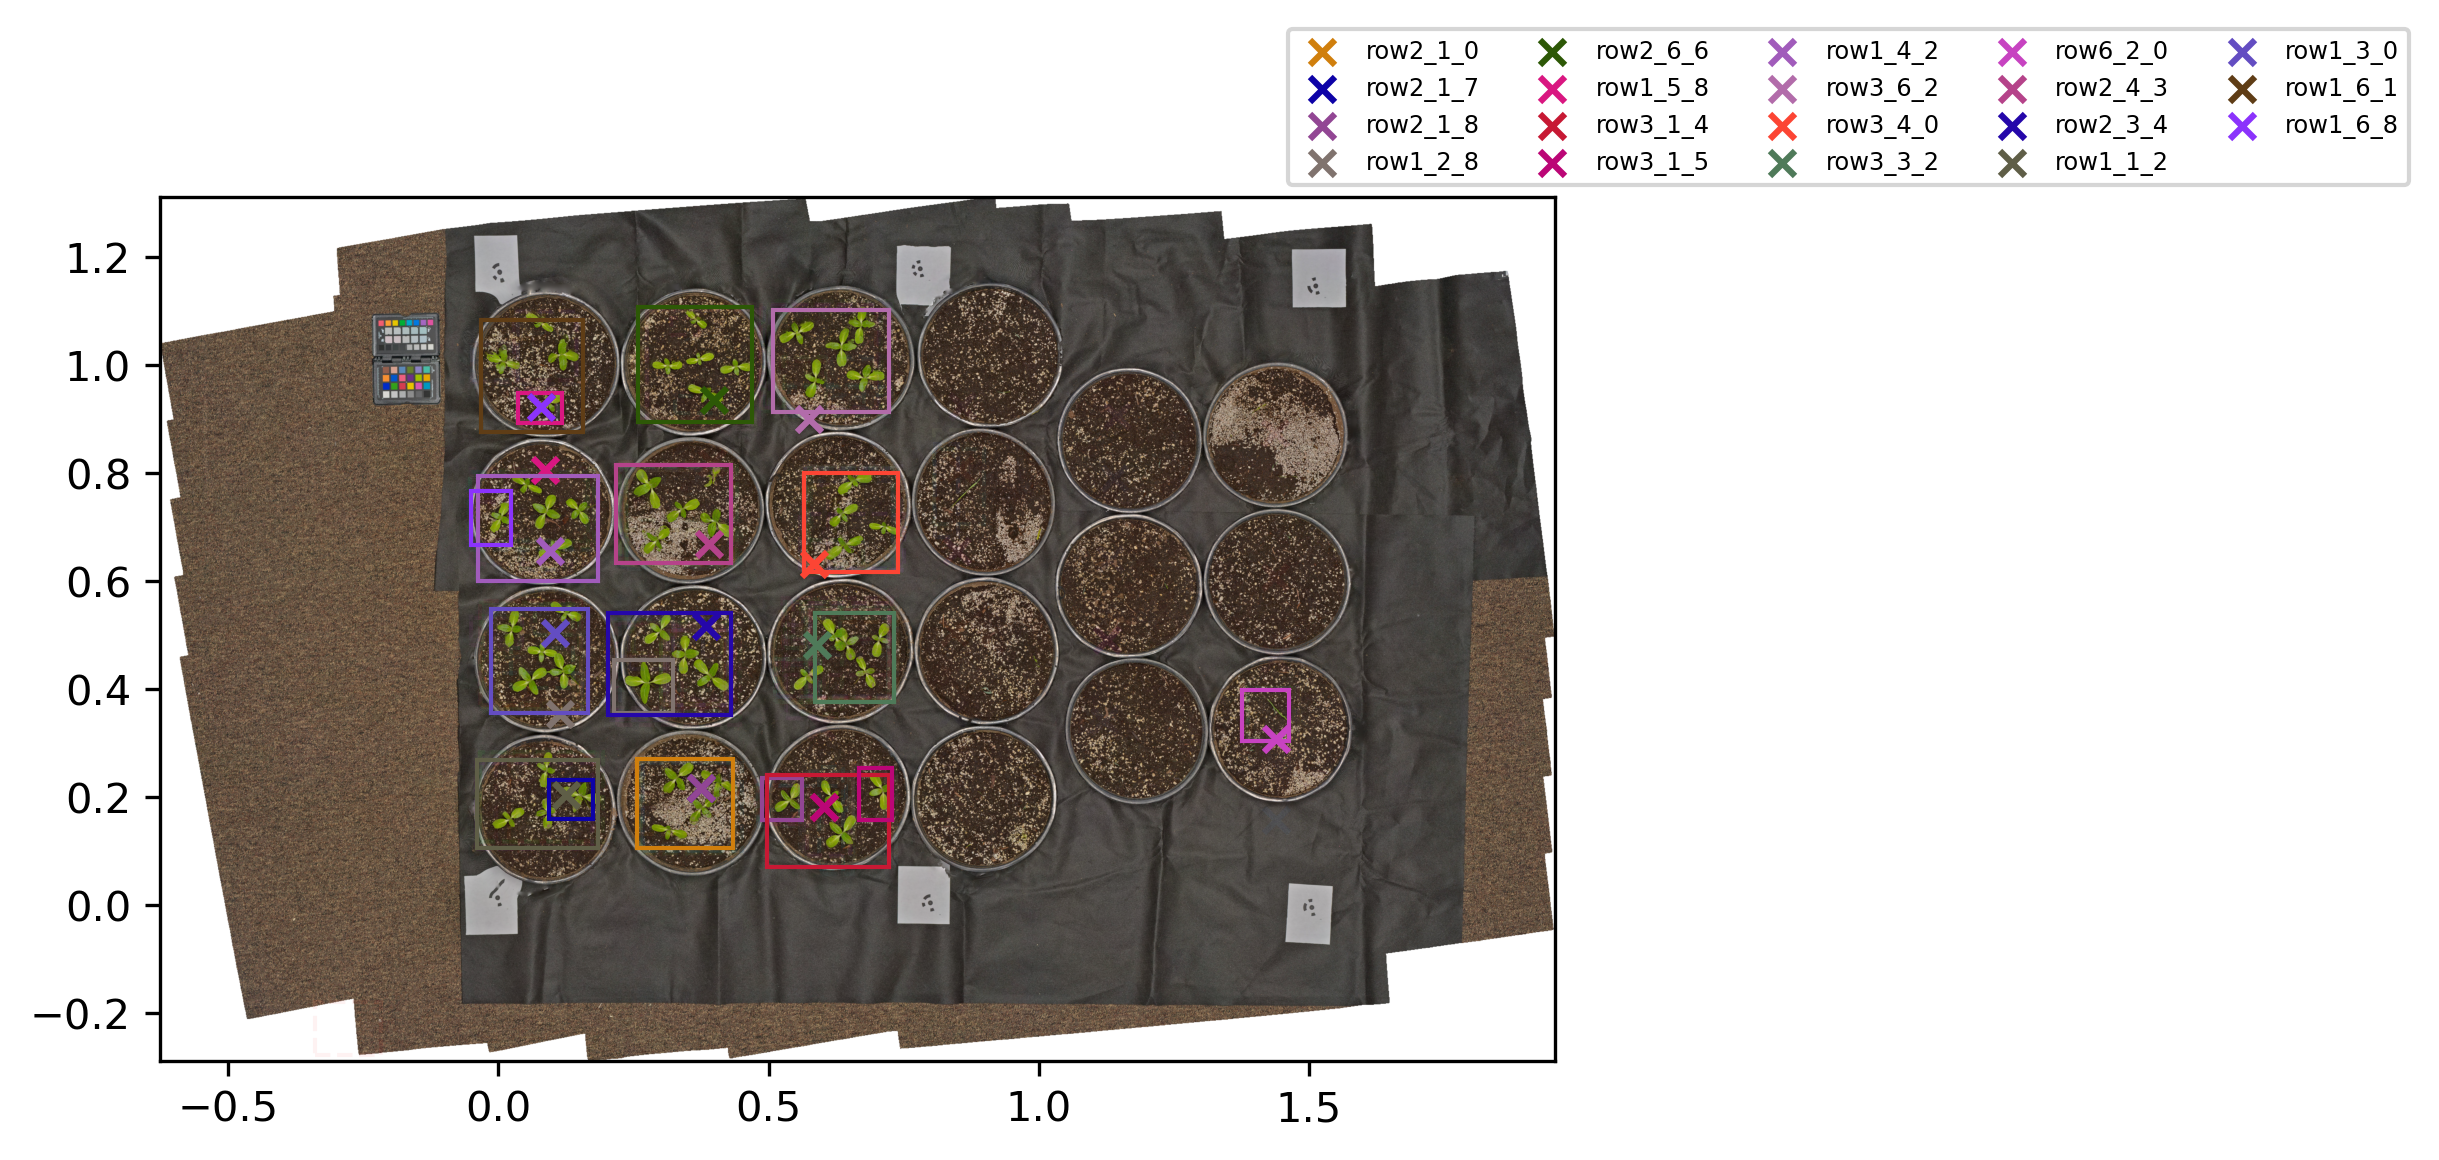

In [11]:
plot_rectangle(box_metadata, display_orthomosaic=True, seed=424242)